In [22]:
#password : 
#YSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS="notebook --ip=10.129.5.252 --port=8888 --allow-root" pyspark

In [53]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import *
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, IndexToString, OneHotEncoder
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, avg, stddev, mean, min, max, to_timestamp, udf, lit
from math import radians, sin, cos, sqrt, atan2
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans
#import tensorflow as tf
#import tensorflowonspark as tfos




In [3]:
# spark = SparkSession.builder \
# .master("local") \
# .appName("USGS") \
# .getOrCreate()

spark = SparkSession.builder \
.master("spark://10.129.5.252:7077") \
.appName("USGS") \
.getOrCreate()

In [4]:
df = spark.read.option("delimiter", ";").csv("RAW1.csv", header=True)
#df = spark.read.csv('RAW1.csv', header=True)

In [5]:
df.schema
df.dtypes
df.show(1, vertical=True)

-RECORD 0-------------------------------
 time            | 2024-03-30T22:55:... 
 latitude        | -6.3203              
 longitude       | 154.7674             
 depth           | 67.61                
 mag             | 5.1                  
 magType         | mww                  
 nst             | 121                  
 gap             | 60                   
 dmin            | 5.994                
 rms             | 0.58                 
 net             | us                   
 id              | us7000m900           
 updated         | 2024-03-30T23:38:... 
 place           | 79 km W of Pangun... 
 type            | earthquake           
 horizontalError | 9.25                 
 depthError      | 5.366                
 magError        | 0.117                
 magNst          | 7                    
 status          | reviewed             
 locationSource  | us                   
 magSource       | us                   
only showing top 1 row



In [6]:
df = df.withColumn("depth", col("depth").cast("float")) \
       .withColumn("mag", col("mag").cast("float")) \
       .withColumn("time", to_timestamp("time", "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'"))\
       .withColumn("latitude", col("latitude").cast(DoubleType()))\
       .withColumn("longitude", col("longitude").cast(DoubleType()))

In [7]:
df = df.filter((col("depth").isNotNull()) & (col("mag").isNotNull()))

In [8]:
columns_to_keep = ["time", "latitude", "longitude", "depth", "mag", "magType", "nst", "place", "horizontalError", "depthError", "magError"]
df = df.select(columns_to_keep)

In [9]:
categorical_col = "place"
string_indexer = StringIndexer(inputCol=categorical_col, outputCol=f"{categorical_col}_indexed")
encoder = OneHotEncoder(inputCol=f"{categorical_col}_indexed", outputCol=f"{categorical_col}_encoded")
pipeline = Pipeline(stages=[string_indexer, encoder])
pipeline_model = pipeline.fit(df)
df_encoded = pipeline_model.transform(df)


In [10]:
#df = df.dropna()

In [11]:
print("Schema after preprocessing:")
df.printSchema()

Schema after preprocessing:
root
 |-- time: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- depth: float (nullable = true)
 |-- mag: float (nullable = true)
 |-- magType: string (nullable = true)
 |-- nst: string (nullable = true)
 |-- place: string (nullable = true)
 |-- horizontalError: string (nullable = true)
 |-- depthError: string (nullable = true)
 |-- magError: string (nullable = true)



In [12]:
#to create a new feature distance_from_center

# def calculate_distance(lat1, lon1, lat2, lon2):
#     # Radius of the Earth in km
#     R = 6371.0
    
#     # lat and long deg. to rad
#     lat1_rad = radians(lat1)
#     lon1_rad = radians(lon1)
#     lat2_rad = radians(lat2)
#     lon2_rad = radians(lon2)
    
#     # diff
#     dlon = lon2_rad - lon1_rad
#     dlat = lat2_rad - lat1_rad
    
#     # Haversine formula to calculate distance
#     a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
#     c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
#     distance = R * c
#     return distance


# distance_udf = udf(calculate_distance, DoubleType())

# # reminder to put each country center point
# city_center_lat = lit(0.0)
# city_center_lon = lit(0.0)  

# # Apply the UDF 
# df = df_encoded.withColumn('distance_from_center', distance_udf('latitude', 'longitude', city_center_lat, city_center_lon))

# # Show the DataFrame with the new feature
# df.select('latitude', 'longitude', 'distance_from_center').show(5)

In [13]:
df.describe().show()


+-------+------------------+------------------+------------------+-------------------+-------+-----------------+--------------------+-----------------+------------------+--------------------+
|summary|          latitude|         longitude|             depth|                mag|magType|              nst|               place|  horizontalError|        depthError|            magError|
+-------+------------------+------------------+------------------+-------------------+-------+-----------------+--------------------+-----------------+------------------+--------------------+
|  count|            210975|            210975|            210975|             210975| 210975|           101161|              210975|            70964|            122744|               76570|
|   mean|2.0364361292327198| 44.22947686631693| 67.95020244642821|  4.848595073088352|   null|82.42008283824794|                null|8.331994592404786|10.173631511090237| 0.09916718384450256|
| stddev|29.202596836656284|120.61505709

In [14]:
numerical_cols = ['latitude', 'longitude', 'depth', 'mag']
description = df.select(numerical_cols).describe()
summary = description.select(
    col("summary"),
    col("latitude").alias("Latitude"),
    col("longitude").alias("Longitude"),
    col("depth").alias("Depth"),
    col("mag").alias("Magnitude")
)
summary.show()



+-------+------------------+------------------+------------------+-------------------+
|summary|          Latitude|         Longitude|             Depth|          Magnitude|
+-------+------------------+------------------+------------------+-------------------+
|  count|            210975|            210975|            210975|             210975|
|   mean|2.0364361292327198| 44.22947686631693| 67.95020244642821|  4.848595073088352|
| stddev|29.202596836656284|120.61505709823753|115.30436934275816|0.40075299429607814|
|    min|           -84.133|         -179.9997|              -3.0|                4.5|
|    max|            87.386|             180.0|             700.9|                9.1|
+-------+------------------+------------------+------------------+-------------------+



In [15]:
place_counts = df.groupBy('place').count()
mode_place = place_counts.orderBy(F.desc('count')).select('place').first()[0]
print("Mode of 'place' column:", mode_place)

Mode of 'place' column: South Sandwich Islands region


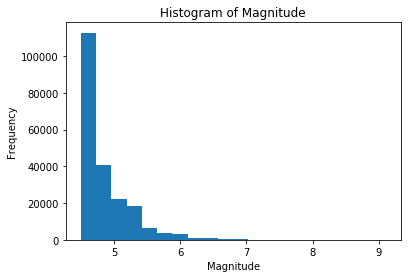

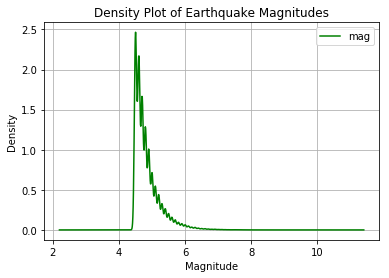

In [37]:
# Histogram of mag
plt.hist(df.select("mag").rdd.flatMap(lambda x: x).collect(), bins=20)
plt.title("Histogram of Magnitude")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.show()

df.select("mag").toPandas().plot.kde(color='green')
plt.title('Density Plot of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Density')
plt.grid(True)
plt.show()

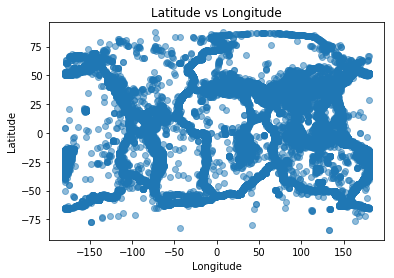

In [17]:
#Scatter plot of Lat vs Long
plt.scatter(df.select("longitude").rdd.flatMap(lambda x: x).collect(), 
            df.select("latitude").rdd.flatMap(lambda x: x).collect(), 
            alpha=0.5)
plt.title("Latitude vs Longitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



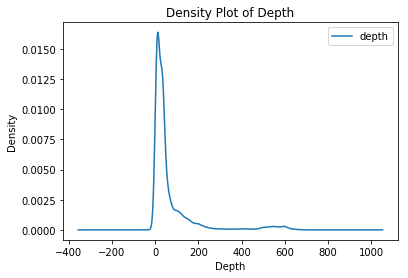

In [18]:
# Density plot of depth
df.select("depth").toPandas().plot.kde()
plt.title("Density Plot of Depth")
plt.xlabel("Depth")
plt.show()

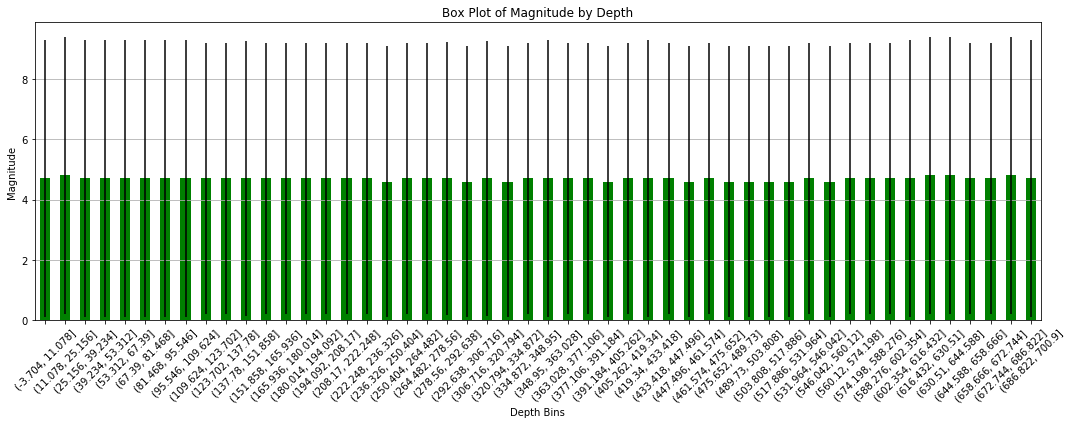

In [19]:
# Convert Spark DataFrame to Pandas DataFrame
df_pd = df.toPandas()

# Define depth ranges and bin the data
depth_bins = pd.cut(df_pd['depth'], bins=50) 
df_pd['Depth_Bin'] = depth_bins

# Group by depth bins and calculate summary statistics for Magnitude
depth_groups = df_pd.groupby('Depth_Bin')['mag']
summary_stats = depth_groups.describe()

# Plot box plots
plt.figure(figsize=(15, 6))
summary_stats['50%'].plot(kind='bar', yerr=[summary_stats['25%'], summary_stats['75%']], color='green')
plt.title('Box Plot of Magnitude by Depth')
plt.xlabel('Depth Bins')
plt.ylabel('Magnitude')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [20]:
# Time analysys with temporal data, 

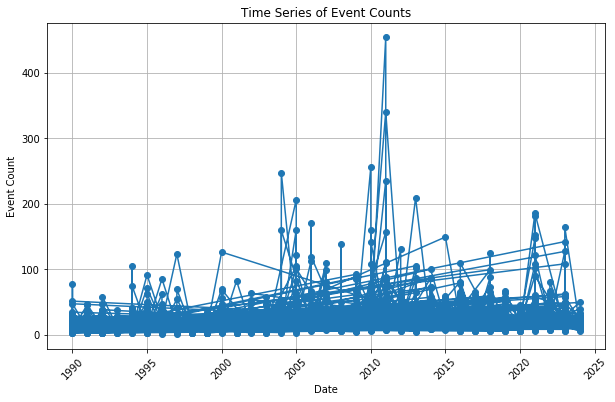

AttributeError: 'Float64Index' object has no attribute 'inferred_freq'

In [21]:
df = df.withColumn("year", F.year("time")) \
       .withColumn("month", F.month("time")) \
       .withColumn("day", F.dayofmonth("time")) \
       .withColumn("hour", F.hour("time")) \
       .withColumn("minute", F.minute("time")) \
       .withColumn("second", F.second("time"))

#aggrigate on diffrent time units
agg_df = df.groupBy("year", "month", "day").agg(F.count("time").alias("count"))

# agg data to pandas df for the plot
agg_pd_df = agg_df.toPandas()
agg_pd_df.set_index('year', inplace=True)

# Plot time series
plt.figure(figsize=(10, 6))
plt.plot(agg_pd_df["count"], marker='o', linestyle='-')
plt.title("Time Series of Event Counts")
plt.xlabel("Date")
plt.ylabel("Event Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


#by season 
decomposition = seasonal_decompose(agg_pd_df["count"], model='additive')
# Plot decomposition
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.title('Seasonality')
plt.subplot(413)
plt.plot(decomposition.resid)
plt.title('Residuals')
plt.subplot(414)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate z-score for anomaly detection
mean = agg_pd_df["count"].mean()
std = agg_pd_df["count"].std()
agg_pd_df["z_score"] = (agg_pd_df["count"] - mean) / std

# Identify anomalies
anomalies = agg_pd_df[agg_pd_df["z_score"] > 3]  # Adjust threshold as needed

# Visualize anomalies
plt.figure(figsize=(10, 6))
plt.plot(agg_pd_df["count"], marker='o', linestyle='-', color='b', label='Event Count')
plt.scatter(anomalies.index, anomalies["count"], color='r', label='Anomalies')
plt.title("Time Series of Event Counts with Anomalies")
plt.xlabel("Date")
plt.ylabel("Event Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Correlation between depth and magnitude: -0.027577852044168277


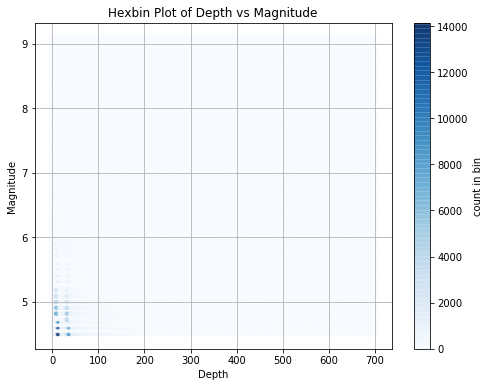

In [33]:
correlation = df.select(F.corr('depth', 'mag')).collect()[0][0]
print("Correlation between depth and magnitude:", correlation)

df_pd = df.select('depth', 'mag').toPandas()

plt.figure(figsize=(8, 6))
plt.hexbin(df_pd['depth'], df_pd['mag'], gridsize=90, cmap='Blues', alpha=0.8)
plt.colorbar(label='count in bin')
plt.title('Hexbin Plot of Depth vs Magnitude')
plt.xlabel('Depth')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

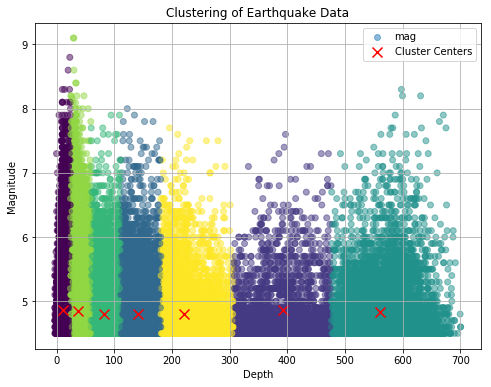

In [40]:
X = df.select("depth", "mag").toPandas()

num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_
plt.figure(figsize=(8, 6))
plt.scatter(X['depth'], X['mag'], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', color='red', s=100, label='Cluster Centers')
plt.title('Clustering of Earthquake Data')
plt.xlabel('Depth')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
try:
    import torch
    print("PyTorch is installed.")
except ImportError:
    print("PyTorch is not installed.")

PyTorch is not installed.


In [49]:
try:
    import keras
    print("Keras is installed.")
except ImportError:
    print("Keras is not installed.")

Keras is not installed.


In [50]:
try:
    import mxnet
    print("MXNet is installed.")
except ImportError:
    print("MXNet is not installed.")

MXNet is not installed.


In [51]:
try:
    import jax
    print("JAX is installed.")
except ImportError:
    print("JAX is not installed.")

JAX is not installed.
